# MNIST with Newton's Method

I'm interested in second order methods. This simple one level model does train surprisingly fast with steepest descent, but I want to see if I can do better. Let's take a look at the Hessian of this model.

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
import tensorflow as tf
from afqstensorutils import CatVariable, NewtonsMethod
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


What do they look like?

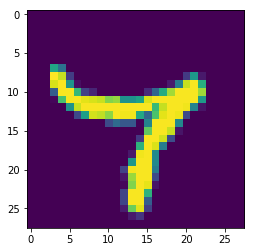

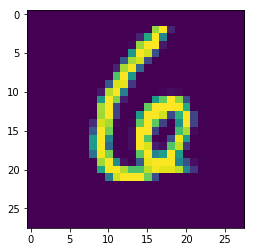

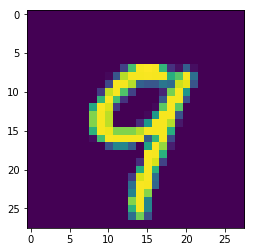

In [5]:
import numpy as np
from matplotlib.pyplot import imshow
from matplotlib import pylab as plt
%matplotlib inline
imshow(mnist.test.images[124,:].reshape(28,28))
plt.show()
imshow(mnist.test.images[123,:].reshape(28,28))
plt.show()
imshow(mnist.test.images[12,:].reshape(28,28))
plt.show()

## The Model

This is the basic softmax regression from the very first tensorflow tutorial. The only parameters are the $W$ and $b$ tensors. 

`CatVariable` is one of my utilities that gives you multiple variables that are actually just one flat variable. This is useful to take complete gradients of models with many variables, as the tensorflow gradient operator requires a flat, "true" variable. So, we use `W` and `b` normally but they are really slices of `V`, which we take the gradients against.

`NewtonsMethod` is a dirt simple implementation. As it turns out, it's not viable for a certain reason.

In [3]:
tf_x = tf.placeholder(tf.float32, shape=[None, 784])
tr_y = tf.placeholder(tf.float32, shape=[None, 10])

# Turns out the b doesn't matter
V, (W,) = CatVariable([(784,10)])
pred_y = tf.nn.softmax(tf.matmul(tf_x,W)) # + b)

cross_entropy = \
  tf.reduce_mean(-tf.reduce_sum(tr_y * tf.log(pred_y),
                                reduction_indices=[1]))
# Get an assembler for the hessian
Hess = tf.reshape(tf.hessians(cross_entropy,V)[0],
                  shape=[V.shape[0],V.shape[0]])
# My trainer and the default one.
newt = NewtonsMethod(cross_entropy, V)
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

Initialize our session with zeros

In [4]:
sess.run(tf.global_variables_initializer())

So, what does the tangent matrix look like? Let's investigate it. The batch size for the stochastic investigation is a free parameter, so lets see how the sparsity pattern (showing us interdependent variables) and the matrix rank changes. (The matrix rank is expensive to compute because it requires an SVD.)

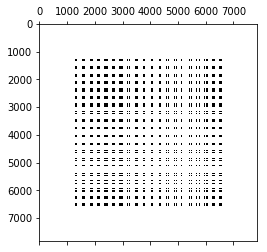

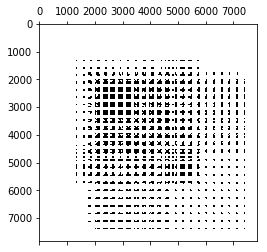

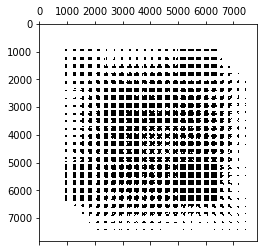

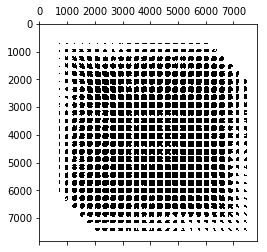

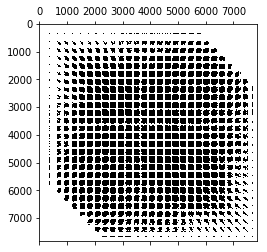

In [5]:
for nassemble in [ 1 , 5, 10, 100, 200 ]:
    batch_xs, batch_ys = mnist.train.next_batch(nassemble)
    m = sess.run(Hess,feed_dict={tf_x: batch_xs, tr_y: batch_ys})
    plt.figure()
    plt.spy(m)
    plt.show()
    #print "It's rank is ", np.linalg.matrix_rank(m)

There's definitely a structure to it. I wonder why there are streeks in it like that? Notice how the matrix fills out more and more as we added more items of evidence to the batch. I had a hunch that the rank of this matrix is nearly the number of items in the batch, but it turns out it comes out larger. For low batch numbers, it looks like $rank=9n$, but the rank filling in slows down as we add more samples. We still notice that we need a lot more sample to get the full rank that we need. 

Let's take a moment to realize how big this tangent matrix is...

In [7]:
m.nbytes/1024/1024

234

In [6]:
m.shape

(7840, 7840)

It's a 7850x7850 dense matrix that takes up 235MB. In terms of side length, it's tiny, but it's dense, which makes it take up a ton of space and pretty expensive to solve on just a laptop. I solve sparse matrices that are 60MB all the time, but beyond that it'll take MPI to get anywhere.

This is how we would do one step with Newton's method. Because we'll _never_ get full rank for this model (see our conclusions below), the matrix will never be solvable and this will never work.

In [8]:
#for _ in range(1):
#  batch_xs, batch_ys = mnist.train.next_batch(100)
#  sess.run(newt,
#           feed_dict={tf_x: batch_xs, tr_y: batch_ys})

Instead, lets train it normally and verify that we get the same accuracy the documentation tells us we should,

In [9]:
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={tf_x: batch_xs, tr_y: batch_ys})
correct_prediction = tf.equal(tf.argmax(pred_y,1), tf.argmax(tr_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={tf_x: mnist.test.images, tr_y: mnist.test.labels}))

0.9123


And lets look at those eigenvectors we get out:

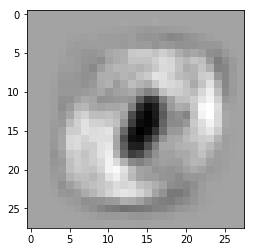

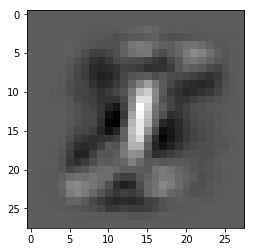

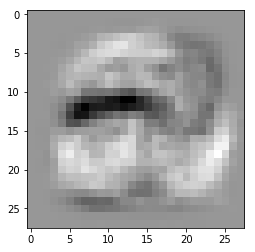

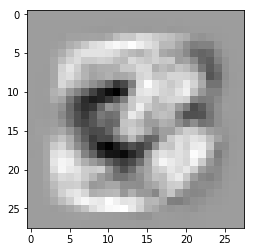

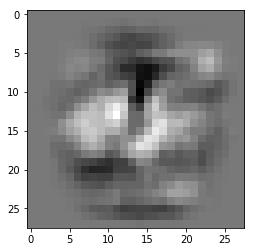

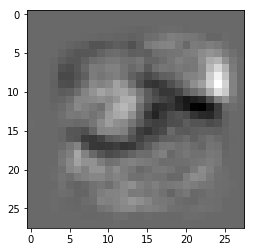

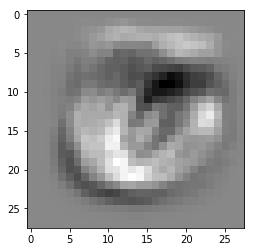

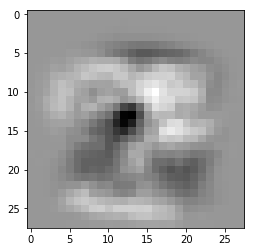

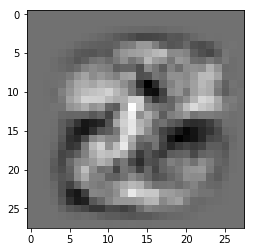

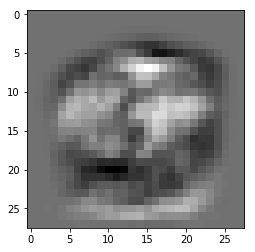

In [10]:
for i in xrange(10):
    imshow(W.eval()[:,i].reshape(28,28),'gray')
    plt.show()

Let's investigate something. How does the process change as if we change the initial conditions? Sometimes we're at a poor location when we start at 0 exactly. This happens in plenty of nonlinear problems with well defined solutions, such as perpendicularly loaded membranes that are exactly flat initially. Let's randomize the variables and redo our investigations:

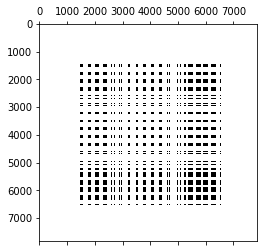

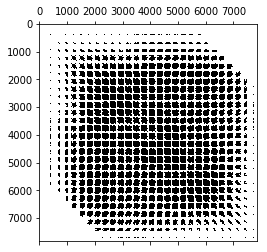

In [11]:
sess.run(tf.assign(V,tf.truncated_normal(shape=V.shape, stddev=0.1)))
for nassemble in [ 1 , 200 ]:
    batch_xs, batch_ys = mnist.train.next_batch(nassemble)
    m = sess.run(Hess,feed_dict={tf_x: batch_xs, tr_y: batch_ys})
    plt.figure()
    plt.spy(m)
    plt.show()

We notice that the tangents don't really change, so the zero components aren't filled in by giving $W$ nonzero values. Does the training process and resulting targets change?

In [12]:
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={tf_x: batch_xs, tr_y: batch_ys})
correct_prediction = tf.equal(tf.argmax(pred_y,1), tf.argmax(tr_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={tf_x: mnist.test.images, tr_y: mnist.test.labels}))

0.9146


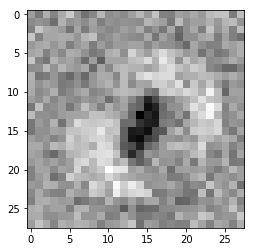

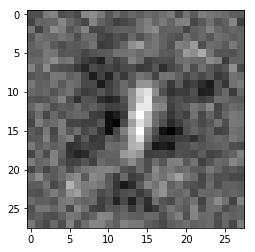

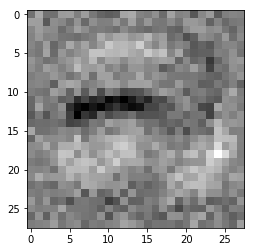

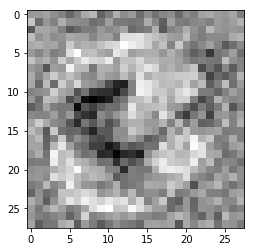

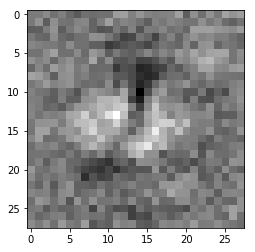

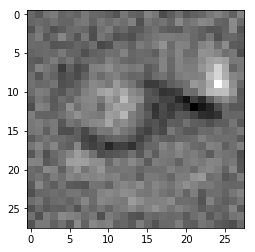

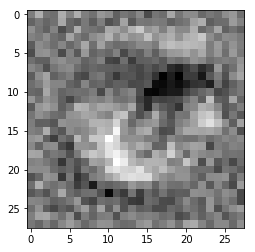

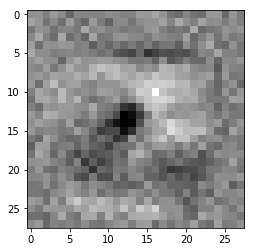

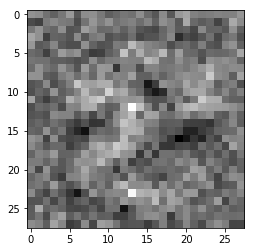

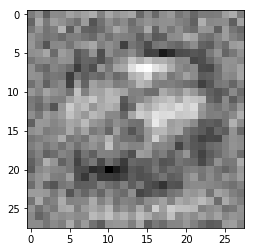

In [13]:
for i in xrange(10):
    imshow(W.eval()[:,i].reshape(28,28),'gray')
    plt.show()

So we get the same accuracy, similar structures to the weights, but there's still a ton of noise! This makes sense: the pixels around the edges are all 0, so those nodes never get any penalty. This explains why we'll never reach full rank in our hessian. Pixels without any evidence in this model are unimportant to the results.

1. A lot of the parameters in our model are useless.
2. We need a regularization scheme to make sure the rank-deficient degrees of freedom will be constrained. 

I tried to make a simple regularization scheme based on taking a laplacian of the weights, but you can't take the hessian of a conv2d, so we can't try applying Newton's method.

# Regularization

My gut instinct is to take a Laplacian as a way to kill entropy. This snippet is the finite difference laplacian hacked into the convolution operations from the [PDE example in the documentation](https://www.tensorflow.org/tutorials/pdes):

In [6]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a, dtype=1)
def simple_conv(x, k): 
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='SAME')
  return y[0, :, :, 0]
def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.5, 1.0, 0.5],
                           [1.0, -6., 1.0],
                           [0.5, 1.0, 0.5]])
  return simple_conv(x, laplace_k)

To apply it as a penalty, we take the laplacian of each slice of the $W$ weights, sum the squares of each pixel, and add the sum to the original cross entropy cost function $\Pi$:

$$
\Pi' = \Pi + \epsilon \sum_{n=0}^{10} \left[ \sum_i\sum_j \left(\nabla^2 W_{ij}^{[k]}\right)^2 \right ]
$$

where $\epsilon$ is a sufficiently small parameter to not interfere with the results, but large enough to fully constrain the problem numerically.

In [9]:
regu = sum([ 
    tf.reduce_sum(tf.pow(laplace(tf.reshape(W[:,i],(28,28))),2))
    for i in xrange(W.shape[-1]) ])
PI = cross_entropy + 0.001*regu
train_regu = tf.train.GradientDescentOptimizer(0.5).minimize(PI)

Now let's repeat the training process and watch the evolution of the one of the weights

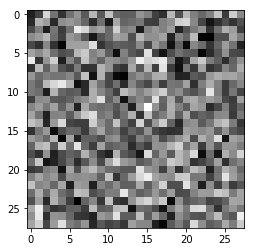

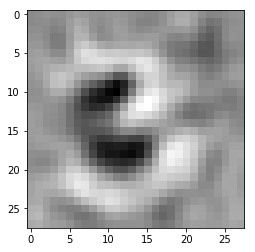

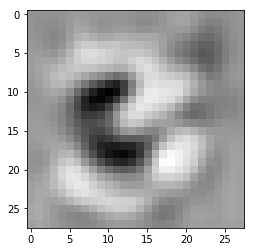

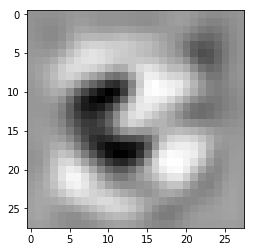

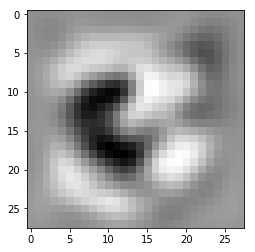

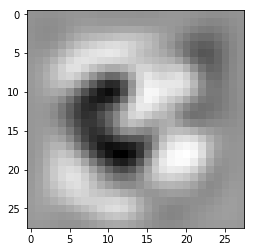

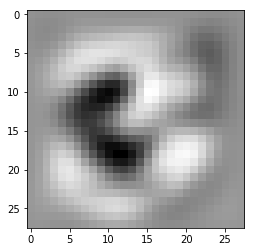

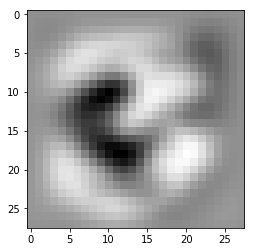

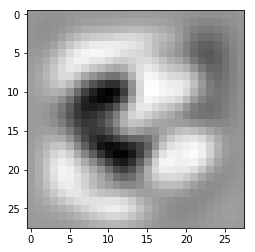

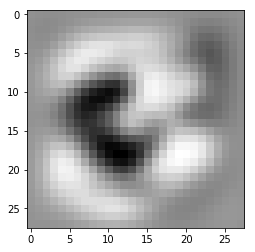

0.9113


In [10]:
sess.run(tf.global_variables_initializer())
sess.run(tf.assign(V,tf.truncated_normal(shape=V.shape, stddev=0.1)))
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_regu, feed_dict={tf_x: batch_xs, tr_y: batch_ys})
  if _%100==0:
    plt.imshow(W.eval()[:,3].reshape(28,28),'gray')
    plt.show()
correct_prediction = tf.equal(tf.argmax(pred_y,1), tf.argmax(tr_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={tf_x: mnist.test.images, tr_y: mnist.test.labels}))

Cool vizualization, huh? We achieve a similar accuracy, but we've suppressed all of that artificially introduced noise. We see that now all of the nodes have well defined values. However, we aren't able to generate the Hessian matrix because the neccessary gradients of the gradient aren't registered for the convolutions, so we can't try out Newton's method.